In [1]:
import pandas as pd
import numpy as np
import dask
import dask.dataframe as dd

# Data importing

In [11]:
# importing data with dask
df_2017 = dd.read_parquet("/content/drive/MyDrive/BigData/yellow_taxi_2017/*.parquet", engine='pyarrow')
df_2021 = dd.read_parquet("/content/drive/MyDrive/BigData/yellow_taxi_2021/*.parquet", engine='pyarrow')

In [ ]:
# checking the data types of the columns
# there are 3 non-numerical columns
df_2021.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [ ]:
# the original data set contained 113.500.327 rows
# it was too large, so we narrowed the data set with pandas dataframe [:(df_2021.shape[0]/12)]
df_2017.shape[0].compute()

30904308

In [ ]:
df_2021.shape[0].compute()

30904308

#Data cleansing and feature engineering - year 2017

In [ ]:
# check the number of NAs
# assumption: maybe airport_fee and congestion_surcharge can be droped
df_2017.isnull().sum().compute().sort_values(ascending=False)

airport_fee              30904308
congestion_surcharge     30904308
fare_amount                     0
total_amount                    0
improvement_surcharge           0
tolls_amount                    0
tip_amount                      0
mta_tax                         0
extra                           0
VendorID                        0
tpep_pickup_datetime            0
DOLocationID                    0
PULocationID                    0
store_and_fwd_flag              0
RatecodeID                      0
trip_distance                   0
passenger_count                 0
tpep_dropoff_datetime           0
payment_type                    0
dtype: int64

In [26]:
# fill NAs with 0
df_2017 = df_2017.fillna(0)

In [4]:
# filtering outliers of tip_amount

# calculate interquartile range
q25, q75 = np.percentile(df_2017['tip_amount'], 25), np.percentile(df_2017['tip_amount'], 75)
iqr = q75 - q25

# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

Identified outliers: 1667160


In [15]:
df_2017.shape[0].compute()

0

In [31]:
df_2017.tip_amount.max().compute()

393.94

In [ ]:
!pip install hvplot

In [34]:
import hvplot.dask

df_2017.hvplot.hist(y="tip_amount")

:Histogram   [tip_amount]   (tip_amount_count)

In [ ]:
# based on our data dictionary, convert store and forward flag's yes/no label to 1/0

df_2017['store_and_fwd_flag'] = df_2017['store_and_fwd_flag'].mask(df_2017['store_and_fwd_flag'] == 'N', '0').mask(df_2017['store_and_fwd_flag'] == 'Y', '1')
df_2017['store_and_fwd_flag'] = df_2017['store_and_fwd_flag'].astype(str).astype(int)

In [ ]:
# calculating and adding a new column concerning to the difference between the pickup and dropoff datetime gaining the travel time by trips

df_2017['tpep_pickup_datetime'] = dd.to_datetime(df_2017['tpep_pickup_datetime'])
df_2017['tpep_dropoff_datetime'] = dd.to_datetime(df_2017['tpep_dropoff_datetime'])
df_2017['date'] = df_2017['tpep_pickup_datetime'].dt.normalize()
df_2017['time'] = df_2017['tpep_pickup_datetime'].dt.hour
df_2017['weekday'] = df_2017['date'].dt.day_name()
df_2017['duration'] = df_2017['tpep_dropoff_datetime'] - df_2017['tpep_pickup_datetime']
df_2017['duration'] = df_2017['duration'] / np.timedelta64(1, 'm')

In [ ]:
# calulating the speed with the proportion of distance and travel time to identify if the trip was in an adequate timeframe or not

df_2017['speed'] = df_2017['trip_distance'] / (df_2017['duration']/60) #get miles per hour

#calculating the mean of speed
df_2017['speed'].replace([np.inf, -np.inf], np.nan)
mean_of_speed_2017 = df_2017['speed'].mean().compute()

# creating three categories: 0: below average, 1: above average
def assignNewLabels(label):
    if label < mean_of_speed_2017:
        return 0
    else:
        return 1

df_2017['speed_category'] = df_2017['speed'].apply(assignNewLabels)

/usr/local/lib/python3.8/dist-packages/dask/dataframe/core.py:3778: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('speed', 'int64'))

  warnings.warn(meta_warning(meta))


In [ ]:
# calculating tip percentage using tip amount and total amount
df_2017['tip_percent'] = (df_2017.tip_amount / df_2017.total_amount) * 100

In [ ]:
# classifying a trip's time slot
def time_slots(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,17):
        return 'Afternoon'
    elif x in range(17,22):
        return 'Evening'
    else:
        return 'Late Night'

df_2017['time_desc'] = df_2017['time'].apply(time_slots)

/usr/local/lib/python3.8/dist-packages/dask/dataframe/core.py:3778: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('time', 'object'))

  warnings.warn(meta_warning(meta))


In [ ]:
# aggregating monthly data by seasons
spring_2017 = dd.concat([df_2017.get_partition(2),df_2017.get_partition(3),df_2017.get_partition(4)]).reset_index(drop=True)
summer_2017 = dd.concat([df_2017.get_partition(5),df_2017.get_partition(6),df_2017.get_partition(7)]).reset_index(drop=True)
autumn_2017 = dd.concat([df_2017.get_partition(8),df_2017.get_partition(9),df_2017.get_partition(10)]).reset_index(drop=True)
winter_2017 = dd.concat([df_2017.get_partition(11),df_2017.get_partition(0),df_2017.get_partition(1)]).reset_index(drop=True)

In [ ]:
# print number of data rows in every seasons:
print("The number of data rows in 2021 spring: ",spring_2017.shape[0].compute(),
      "\nThe number of data rows in 2021 summer: ",summer_2017.shape[0].compute(),
      "\nThe number of data rows in 2021 autumn: ",autumn_2017.shape[0].compute(),
      "\nThe number of data rows in 2021 winter: ",winter_2017.shape[0].compute())

The number of data rows in 2021 spring:  7726077 
The number of data rows in 2021 summer:  7726077 
The number of data rows in 2021 autumn:  7726077 
The number of data rows in 2021 winter:  7726077


In [ ]:
# labeling dataset with seasons
spring_2017['season'] = 'spring'
summer_2017['season'] = 'summer'
autumn_2017['season'] = 'autumn'
winter_2017['season'] = 'winter'

In [ ]:
# updating the original dataset with seasons
df_2017 = dd.concat([spring_2017, summer_2017, autumn_2017, winter_2017]).reset_index(drop=True)

#Data cleansing and feature engineering - year 2021

In [ ]:
# check the number of NAs
# assumption: maybe airport_fee can be droped
df_2021.isnull().sum().compute().sort_values(ascending=False)

airport_fee              5641418
congestion_surcharge     1478695
passenger_count          1478695
RatecodeID               1478695
store_and_fwd_flag       1478695
extra                          0
total_amount                   0
improvement_surcharge          0
tolls_amount                   0
tip_amount                     0
mta_tax                        0
VendorID                       0
fare_amount                    0
tpep_pickup_datetime           0
DOLocationID                   0
PULocationID                   0
trip_distance                  0
tpep_dropoff_datetime          0
payment_type                   0
dtype: int64

In [12]:
# fill NAs with 0
df_2021 = df_2021.fillna(0)

In [13]:
# based on our data dictionary, convert store and forward flag's yes/no label to 1/0

df_2021['store_and_fwd_flag'] = df_2021['store_and_fwd_flag'].mask(df_2021['store_and_fwd_flag'] == 'N', '0').mask(df_2021['store_and_fwd_flag'] == 'Y', '1')

In [14]:
# calculating and adding a new column concerning to the difference between the pickup and dropoff datetime gaining the travel time by trips

df_2021['tpep_pickup_datetime'] = dd.to_datetime(df_2021['tpep_pickup_datetime'])
df_2021['tpep_dropoff_datetime'] = dd.to_datetime(df_2021['tpep_dropoff_datetime'])
df_2021['date'] = df_2021['tpep_pickup_datetime'].dt.normalize()
df_2021['time'] = df_2021['tpep_pickup_datetime'].dt.hour
df_2021['weekday'] = df_2021['date'].dt.day_name()
df_2021['duration'] = df_2021['tpep_dropoff_datetime'] - df_2021['tpep_pickup_datetime']
df_2021['duration'] = df_2021['duration'] / np.timedelta64(1, 'm')

In [17]:
# calulating the speed with the proportion of distance and travel time to identify if the trip was in an adequate timeframe or not

df_2021['speed'] = df_2021['trip_distance'] / (df_2021['duration']/60) #get miles per hour

#calculating the mean of speed
df_2021['speed'].replace([np.inf, -np.inf], np.nan)
mean_of_speed_2021 = df_2021['speed'].mean().compute()

# creating three categories: 0: below average, 1: above average
def assignNewLabels(label):
    if label < mean_of_speed_2021:
        return 0
    else:
        return 1

df_2021['speed_category'] = df_2021['speed'].apply(assignNewLabels)

/usr/local/lib/python3.8/dist-packages/dask/dataframe/core.py:3778: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('speed', 'int64'))

  warnings.warn(meta_warning(meta))


In [15]:
# calculating tip percentage using tip amount and total amount
df_2021['tip_percent'] = (df_2021.tip_amount / df_2021.total_amount) * 100

In [16]:
# classifying a trip's time slot
def time_slots(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,17):
        return 'Afternoon'
    elif x in range(17,22):
        return 'Evening'
    else:
        return 'Late Night'

df_2021['time_desc'] = df_2021['time'].apply(time_slots)

/usr/local/lib/python3.8/dist-packages/dask/dataframe/core.py:3778: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('time', 'object'))

  warnings.warn(meta_warning(meta))


In [18]:
# aggregating monthly data by seasons
spring_2021 = pd.DataFrame()
summer_2021 = pd.DataFrame()
autumn_2021 = pd.DataFrame()
winter_2021 = pd.DataFrame()

for i in range(12):
  if (i>=2 and i<=4):
    spring_2021 = dd.concat([spring_2021,df_2021.get_partition(i)]).reset_index(drop=True)
  elif (i>=5 and i<=7):
    summer_2021 = dd.concat([summer_2021,df_2021.get_partition(i)]).reset_index(drop=True)
  elif (i>=8 and i<=10):
    autumn_2021 = dd.concat([autumn_2021,df_2021.get_partition(i)]).reset_index(drop=True)
  else:
    winter_2021 = dd.concat([winter_2021,df_2021.get_partition(i)]).reset_index(drop=True)

In [ ]:
# print number of data rows in every seasons:
print("The number of data rows in 2021 spring: ",spring_2021.shape[0].compute(),
      "\nThe number of data rows in 2021 summer: ",summer_2021.shape[0].compute(),
      "\nThe number of data rows in 2021 autumn: ",autumn_2021.shape[0].compute(),
      "\nThe number of data rows in 2021 winter: ",winter_2021.shape[0].compute())

The number of data rows in 2021 spring:  6603448 
The number of data rows in 2021 summer:  8444767 
The number of data rows in 2021 autumn:  9900246 
The number of data rows in 2021 winter:  5955847


In [19]:
# labeling dataset with seasons
spring_2021['season'] = 'spring'
summer_2021['season'] = 'summer'
autumn_2021['season'] = 'autumn'
winter_2021['season'] = 'winter'

In [20]:
# updating the original dataset with seasons
df_2021 = dd.concat([spring_2021, summer_2021, autumn_2021, winter_2021]).reset_index(drop=True)

#Data preparation for modelling - year 2017

In [ ]:
# further numerical conversion before finalising the modelling set
seasons = {'spring':0, 'summer':1, 'autumn':2, 'winter':3}
df_2017['season_num'] = df_2017['season'].map(seasons)

days = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
df_2017['weekday_num'] = df_2017['weekday'].map(days)

time_desc = {'Morning':0, 'Afternoon':1, 'Evening':2, 'Late Night':3}
df_2017['time_desc_num'] = df_2017['time_desc'].map(time_desc)

In [ ]:
# selecting the relevant features for modelling
colsNotToInclude = ['airport_fee','tpep_pickup_datetime','tpep_dropoff_datetime','season','weekday','time_desc','date', 'tip_amount', 'congestion_surcharge']
features = [col for col in df_2017.columns if col not in colsNotToInclude]
df_2017_for_modelling = df_2017[features]
df_2017_target = df_2017['tip_amount']

In [ ]:
df_2017_target.to_frame().to_parquet('/content/drive/MyDrive/BigData/yellow_taxi_2017/2017_TARGET.parquet')

(None,)

In [ ]:
df_2017_for_modelling.get_partition(1).compute().head()

VendorID  passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
0       1.0              1.0            1.2         1.0                 0.0   
1       1.0              2.0            0.7         1.0                 0.0   
2       1.0              2.0            0.8         1.0                 0.0   
3       1.0              1.0            1.1         1.0                 0.0   
4       1.0              1.0            3.0         1.0                 0.0   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  ...  \
0         140.0         236.0           2.0          6.5    0.5  ...   
1         237.0         140.0           2.0          5.0    0.5  ...   
2         140.0         237.0           2.0          5.5    0.5  ...   
3          41.0          42.0           2.0          6.0    0.5  ...   
4          48.0         263.0           2.0         11.0    0.5  ...   

   total_amount  congestion_surcharge  time   duration  tip_percent  \
0           7.8                     0   0.0   5.716667          0.0   
1           6.3                     0   0.0   4.283333          0.0   
2           6.8                     0   0.0   4.716667          0.0   
3           7.3                     0   0.0   4.450000          0.0   
4          12.3                     0   0.0  10.583333          0.0   

       speed  speed_category  season_num  weekday_num  time_desc_num  
0  12.594752               0           0            6              3  
1   9.805447               0           0            6              3  
2  10.176678               0           0            6              3  
3  14.831461               0           0            6              3  
4  17.007874               0           0            6              3  

[5 rows x 23 columns]

In [ ]:
df_2017_for_modelling['store_and_fwd_flag'] = df_2017_for_modelling.store_and_fwd_flag.astype(int).compute()

In [ ]:
!pip install dask_ml

In [ ]:
# standardization of a dataset is a common requirement for many machine learning estimators
# they might behave badly if the individual features do not more or less look like standard normally distributed data
# therefore we should standardize features by removing the mean and scaling to unit variance
import dask_ml
from dask_ml.preprocessing import StandardScaler

scaler = StandardScaler()
df_2017_for_modelling = scaler.fit_transform(df_2017_for_modelling)

/usr/local/lib/python3.7/dist-packages/dask/array/reductions.py:717: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/usr/local/lib/python3.7/dist-packages/dask/array/reductions.py:717: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/usr/local/lib/python3.7/dist-packages/dask/array/reductions.py:717: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/usr/local/lib/python3.7/dist-packages/dask/array/reductions.py:717: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/usr/local/lib/python3.7/dist-packages/dask/array/reductions.py:717: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, or

In [ ]:
df_2017_for_modelling.to_parquet('/content/drive/MyDrive/BigData/yellow_taxi_2017/2017_ALL2_scaled_values.parquet', engine = 'pyarrow')

(None,)

#Data preparation for modelling - year 2021

In [21]:
# further numerical conversion before finalising the modelling set
seasons = {'spring':0, 'summer':1, 'autumn':2, 'winter':3}
df_2021['season_num'] = df_2021['season'].map(seasons)

days = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
df_2021['weekday_num'] = df_2021['weekday'].map(days)

time_desc = {'Morning':0, 'Afternoon':1, 'Evening':2, 'Late Night':3}
df_2021['time_desc_num'] = df_2021['time_desc'].map(time_desc)

In [22]:
# selecting the relevant features for modelling
colsNotToInclude = ['airport_fee','tpep_pickup_datetime','tpep_dropoff_datetime','season','weekday','time_desc','date', 'tip_amount', 'congestion_surcharge']
features = [col for col in df_2021.columns if col not in colsNotToInclude]
df_2021_for_modelling = df_2021[features]
df_2021_target = df_2021['tip_amount']

In [15]:
df_2021_target.to_frame().to_parquet('/content/drive/MyDrive/BigData/2021_TARGET.parquet')

(None,)

In [ ]:
df_2021_for_modelling.head()

VendorID  passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
0         1              1.0           2.10         1.0                   0   
1         1              1.0           0.20         1.0                   0   
2         1              1.0          14.70         1.0                   0   
3         1              0.0          10.60         1.0                   0   
4         2              1.0           4.94         1.0                   0   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  ...  \
0           142            43             2          8.0    3.0  ...   
1           238           151             2          3.0    0.5  ...   
2           132           165             1         42.0    0.5  ...   
3           138           132             1         29.0    0.5  ...   
4            68            33             1         16.5    0.5  ...   

   total_amount  congestion_surcharge  time   duration      speed  \
0         11.80                   2.5     0   6.033333  20.883978   
1          4.30                   0.0     0   0.983333  12.203390   
2         51.95                   0.0     0  27.600000  31.956522   
3         36.35                   0.0     0  15.216667  41.796276   
4         24.36                   2.5     0  16.533333  17.927419   

   speed_category  tip_percent  season_num  weekday_num  time_desc_num  
0               1     0.000000           3            4              3  
1               0     0.000000           3            4              3  
2               1    16.650626           3            4              3  
3               1    16.643741           3            4              3  
4               1    16.666667           3            4              3  

[5 rows x 24 columns]

In [27]:
df_2021_for_modelling['store_and_fwd_flag'] = df_2021_for_modelling['store_and_fwd_flag'].astype(str).astype(int)

In [29]:
# standardization of a dataset is a common requirement for many machine learning estimators
# they might behave badly if the individual features do not more or less look like standard normally distributed data
# therefore we should standardize features by removing the mean and scaling to unit variance
import dask_ml
from dask_ml.preprocessing import StandardScaler

scaler = StandardScaler()
df_2021_for_modelling = scaler.fit_transform(df_2021_for_modelling)

/usr/local/lib/python3.8/dist-packages/dask/array/reductions.py:717: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/usr/local/lib/python3.8/dist-packages/dask/array/reductions.py:717: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/usr/local/lib/python3.8/dist-packages/dask/array/reductions.py:717: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/usr/local/lib/python3.8/dist-packages/dask/array/reductions.py:717: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, order + 1)]
/usr/local/lib/python3.8/dist-packages/dask/array/reductions.py:717: RuntimeWarning: invalid value encountered in subtract
  xs = [sum((A - u) ** i, dtype=dtype, **kwargs) for i in range(2, or

In [30]:
df_2021_for_modelling.to_parquet('/content/drive/MyDrive/BigData/2021_ALL2_scaled_values.parquet', engine = 'pyarrow')

(None,)

#EDA

### Histogram of trip amount

In [ ]:
df_2017["tpep_pickup_datetime"].hist(bins=50, figsize=(12,4))
plt.title("Histogram trip amount");

In [ ]:
df_2021["tpep_pickup_datetime"].hist(bins=50, figsize=(12,4))
plt.title("Histogram trip amount");

### Distance and Time Visualization
- The longer the distance between pickup and dropoff locations, the higher the fare.
- Some trips, like to/from an airport are fixed fee.
- Fare at night is different from the day time.

In [ ]:
# Histogram of Distance - 2017

df_2017["trip_distance"].hist(bins=50, figsize=(12,4))
plt.title("Histogram ride distance in miles");

In [ ]:
# Histogram of Distance - 2021

df_2021["trip_distance"].hist(bins=50, figsize=(12,4))
plt.title("Histogram ride distance in miles");

In [ ]:
# It seems most rides are just short rides

df_2017.groupby('passenger_count')['trip_distance','fare_amount'].mean()

In [ ]:
df_2021.groupby('passenger_count')['trip_distance','fare_amount'].mean()

#### Scatter Plot distance and Tip

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(df_2017["trip_distance"], df_2017["tip_amount"], alpha=0.2)
axs[0].set_xlabel("distance mile")
axs[0].set_ylabel("Tip $USD")
axs[0].set_title("All Data")

In [ ]:
# Zoom-in some part of the data
idx = ((df_2017['trip_distance'] < 15) & (df_2017["fare_amount"] < 100))
axs[1].scatter(df_2017[idx]["trip_distance"], df_2017[idx]["fare_amount"], alpha=0.2)
axs[1].set_xlabel("distance mile")
axs[1].set_ylabel("Fare $USD")
axs[1].set_title("Zoom in on distance < 15 mile and fare < $100")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(df_2021["trip_distance"], df_2021["tip_amount"], alpha=0.2)
axs[0].set_xlabel("distance mile")
axs[0].set_ylabel("Tip $USD")
axs[0].set_title("All Data")

In [ ]:
# Zoom-in some part of the data
idx = ((df_2021['trip_distance'] < 15) & (df_2021["fare_amount"] < 100))
axs[1].scatter(df_2021[idx]["trip_distance"], df_2021[idx]["fare_amount"], alpha=0.2)
axs[1].set_xlabel("distance mile")
axs[1].set_ylabel("Fare $USD")
axs[1].set_title("Zoom in on distance < 15 mile and fare < $100")

### Visualize tipping behavior

#### Tips percent by different times of the weak

In [ ]:
# 2017
# filter payment type cash, since tips are not recorded in cash payment
tip = df_2017[df_2017['payment_type'] != 2]

In [ ]:
# compute the tipping percentage in each hour through the week
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

tip_percent = tip.groupby(['weekday', 'time'], as_index=False)['tip_percent'].mean()
tip_percent.weekday = pd.Categorical(tip_percent.weekday, categories=cats)
tip_percent = tip_percent.sort_values(['weekday', 'time']).reset_index(drop=True)
tip_percent_heatmap = pd.pivot_table(tip_percent, values='tip_percent', index='weekday', columns='time')

fig, ax = plt.subplots(figsize=(13, 3.5))
sns.heatmap(tip_percent_heatmap, cbar_kws={'label': 'Tip Percentage'}, ax=ax, cmap='coolwarm')
ax.set_ylabel('Weekday')
ax.set_xlabel('Hour of the day')
ax.set_title('Tipping Percent Throughout Different Times of the Week')
plt.show()

In [45]:
# 2021
# filter payment type cash, since tips are not recorded in cash payment
tip = df_2021[df_2021['payment_type'] != 2]

In [ ]:
tip_percent = tip.groupby(['weekday', 'time'], as_index=False)['tip_percent'].mean()
tip_percent.weekday = pd.Categorical(tip_percent.weekday, categories=cats)
tip_percent = tip_percent.sort_values(['weekday', 'time']).reset_index(drop=True)
tip_percent_heatmap = pd.pivot_table(tip_percent, values='tip_percent', index='weekday', columns='time')

fig, ax = plt.subplots(figsize=(13, 3.5))
sns.heatmap(tip_percent_heatmap, cbar_kws={'label': 'Tip Percentage'}, ax=ax, cmap='coolwarm')
ax.set_ylabel('Weekday')
ax.set_xlabel('Hour of the day')
ax.set_title('Tipping Percent Throughout Different Times of the Week')
plt.show()

#### Tips by speed

In [ ]:
# 2017

fig, ax = plt.subplots(figsize=(10, 2))
ax.bar(df_2017['speed'], df_2017['tip_amount'])
ax.set_xlabel('Number of passangers')
ax.set_ylabel('Tips per trip ($)')
plt.xticks(rotation=15,horizontalalignment="right")
plt.show()

In [ ]:
# 2021

fig, ax = plt.subplots(figsize=(10, 2))
ax.bar(df_2021['speed'], df_2021['tip_amount'])
ax.set_xlabel('Number of passangers')
ax.set_ylabel('Tips per trip ($)')
plt.xticks(rotation=15,horizontalalignment="right")
plt.show()

#### Tips by distance - total

In [ ]:
# 2017

fig, ax = plt.subplots(figsize=(10, 2))
ax.bar(df_2017['distance'], df_2017['tip_amount'])
ax.set_xlabel('Number of passangers')
ax.set_ylabel('Tips per trip ($)')
plt.xticks(rotation=15,horizontalalignment="right")
plt.show()

In [ ]:
# 2021

fig, ax = plt.subplots(figsize=(10, 2))
ax.bar(df_2021['distance'], df_2021['tip_amount'])
ax.set_xlabel('Number of passangers')
ax.set_ylabel('Tips per trip ($)')
plt.xticks(rotation=15,horizontalalignment="right")
plt.show()

#### Tips by passanger count

In [ ]:
# 2017

fig, ax = plt.subplots(figsize=(10, 2))
ax.bar(df_2017['passanger_count'], df_2017['tip_amount'])
ax.set_xlabel('Number of passangers')
ax.set_ylabel('Avg tips per trip ($)')
plt.xticks(rotation=15,horizontalalignment="right")
plt.show()

In [ ]:
# 2021

fig, ax = plt.subplots(figsize=(10, 2))
ax.bar(df_2021['passanger_count'], df_2021['tip_amount'])
ax.set_xlabel('Number of passangers')
ax.set_ylabel('Avg tips per trip ($)')
plt.xticks(rotation=15,horizontalalignment="right")
plt.show()

#### Avg tips per zone

In [ ]:
#2017 PU zone

fig, ax = plt.subplots(figsize=(10, 2))
ax.bar(df_2017['PU_Location'], df_2017['tip_amount'])
ax.set_xlabel('PU Zones')
ax.set_ylabel('Avg tips per trip ($)')
plt.xticks(rotation=15,horizontalalignment="right")
plt.show()

In [ ]:
#2017 DO zone

fig, ax = plt.subplots(figsize=(10, 2))
ax.bar(df_2017['DO_Location'], df_2017['tip_amount'])
ax.set_xlabel('DO Zones')
ax.set_ylabel('Avg tips per trip ($)')
plt.xticks(rotation=15,horizontalalignment="right")
plt.show()

In [ ]:
#2021 PU zone

fig, ax = plt.subplots(figsize=(10, 2))
ax.bar(df_2021['PU_Location'], df_2021['tip_amount'])
ax.set_xlabel('PU Zones')
ax.set_ylabel('Avg tips per trip ($)')
plt.xticks(rotation=15,horizontalalignment="right")
plt.show()

In [ ]:
#2021 DO zone

fig, ax = plt.subplots(figsize=(10, 2))
ax.bar(df_2021['DO_Location'], df_2021['tip_amount'])
ax.set_xlabel('DO Zones')
ax.set_ylabel('Avg tips per trip ($)')
plt.xticks(rotation=15,horizontalalignment="right")
plt.show()

#### Tips by seasons, days

In [ ]:
#spring 2021
sp = pd.crosstab(spring_2021['weekday'], spring_2021['time_desc']).reindex(cats, axis=0)
stacked_spring = sp.stack().reset_index().rename(columns={0:'pick_ups'})
stacked_spring.time_desc = pd.Categorical(stacked_spring.time_desc, categories=time_order)

fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(x=stacked_spring.weekday, y=stacked_spring.pick_ups, hue=stacked_spring.time_desc, ax=ax, palette = 'muted', )
ax.set_ylabel('Number of Taxi Trips')
ax.set_xlabel('Day of the week')
ax.set_title('Taxi pickups at different time across the weekdays (Spring)')
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, 1250000)
plt.legend(loc=1, ncol=len(stacked_spring.time_desc), prop={'size': 10.5})
plt.show()

In [ ]:
#summer 2021
sm = pd.crosstab(summer_2021['weekday'], summer_2021['time_desc']).reindex(cats, axis=0)
stacked_summer = sm.stack().reset_index().rename(columns={0:'pick_ups'})
stacked_summer.time_desc = pd.Categorical(stacked_summer.time_desc, categories=time_order)

fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(x=stacked_summer.weekday, y=stacked_summer.pick_ups, hue=stacked_summer.time_desc, ax=ax, palette = 'muted', )
ax.set_ylabel('Number of Taxi Trips')
ax.set_xlabel('Day of the week')
ax.set_title('Taxi pickups at different time across the weekdays (Summer)')
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, 1250000)
plt.legend(loc=1, ncol=len(stacked_summer.time_desc), prop={'size': 10.5})
plt.show()

In [ ]:
#autumn 2021
at = pd.crosstab(autumn_2021['weekday'], autumn_2021['time_desc']).reindex(cats, axis=0)
stacked_autumn = at.stack().reset_index().rename(columns={0:'pick_ups'})
stacked_autumn.time_desc = pd.Categorical(stacked_autumn.time_desc, categories=time_order)

fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(x=stacked_autumn.weekday, y=stacked_autumn.pick_ups, hue=stacked_autumn.time_desc, ax=ax, palette = 'muted', )
ax.set_ylabel('Number of Taxi Trips')
ax.set_xlabel('Day of the week')
ax.set_title('Taxi pickups at different time across the weekdays (Autumn)')
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, 1250000)
plt.legend(loc=1, ncol=len(stacked_autumn.time_desc), prop={'size': 10.5})
plt.show()

In [ ]:
#winter 2021
wt = pd.crosstab(winter_2021['weekday'], winter_2021['time_desc']).reindex(cats, axis=0)
stacked_winter = wt.stack().reset_index().rename(columns={0:'pick_ups'})
stacked_winter.time_desc = pd.Categorical(stacked_winter.time_desc, categories=time_order)

fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(x=stacked_winter.weekday, y=stacked_winter.pick_ups, hue=stacked_winter.time_desc, ax=ax, palette = 'muted', )
ax.set_ylabel('Number of Taxi Trips')
ax.set_xlabel('Day of the week')
ax.set_title('Taxi pickups at different time across the weekdays (Winter)')
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, 1250000)
plt.legend(loc=1, ncol=len(stacked_winter.time_desc), prop={'size': 10.5})
plt.show()

### Correlation

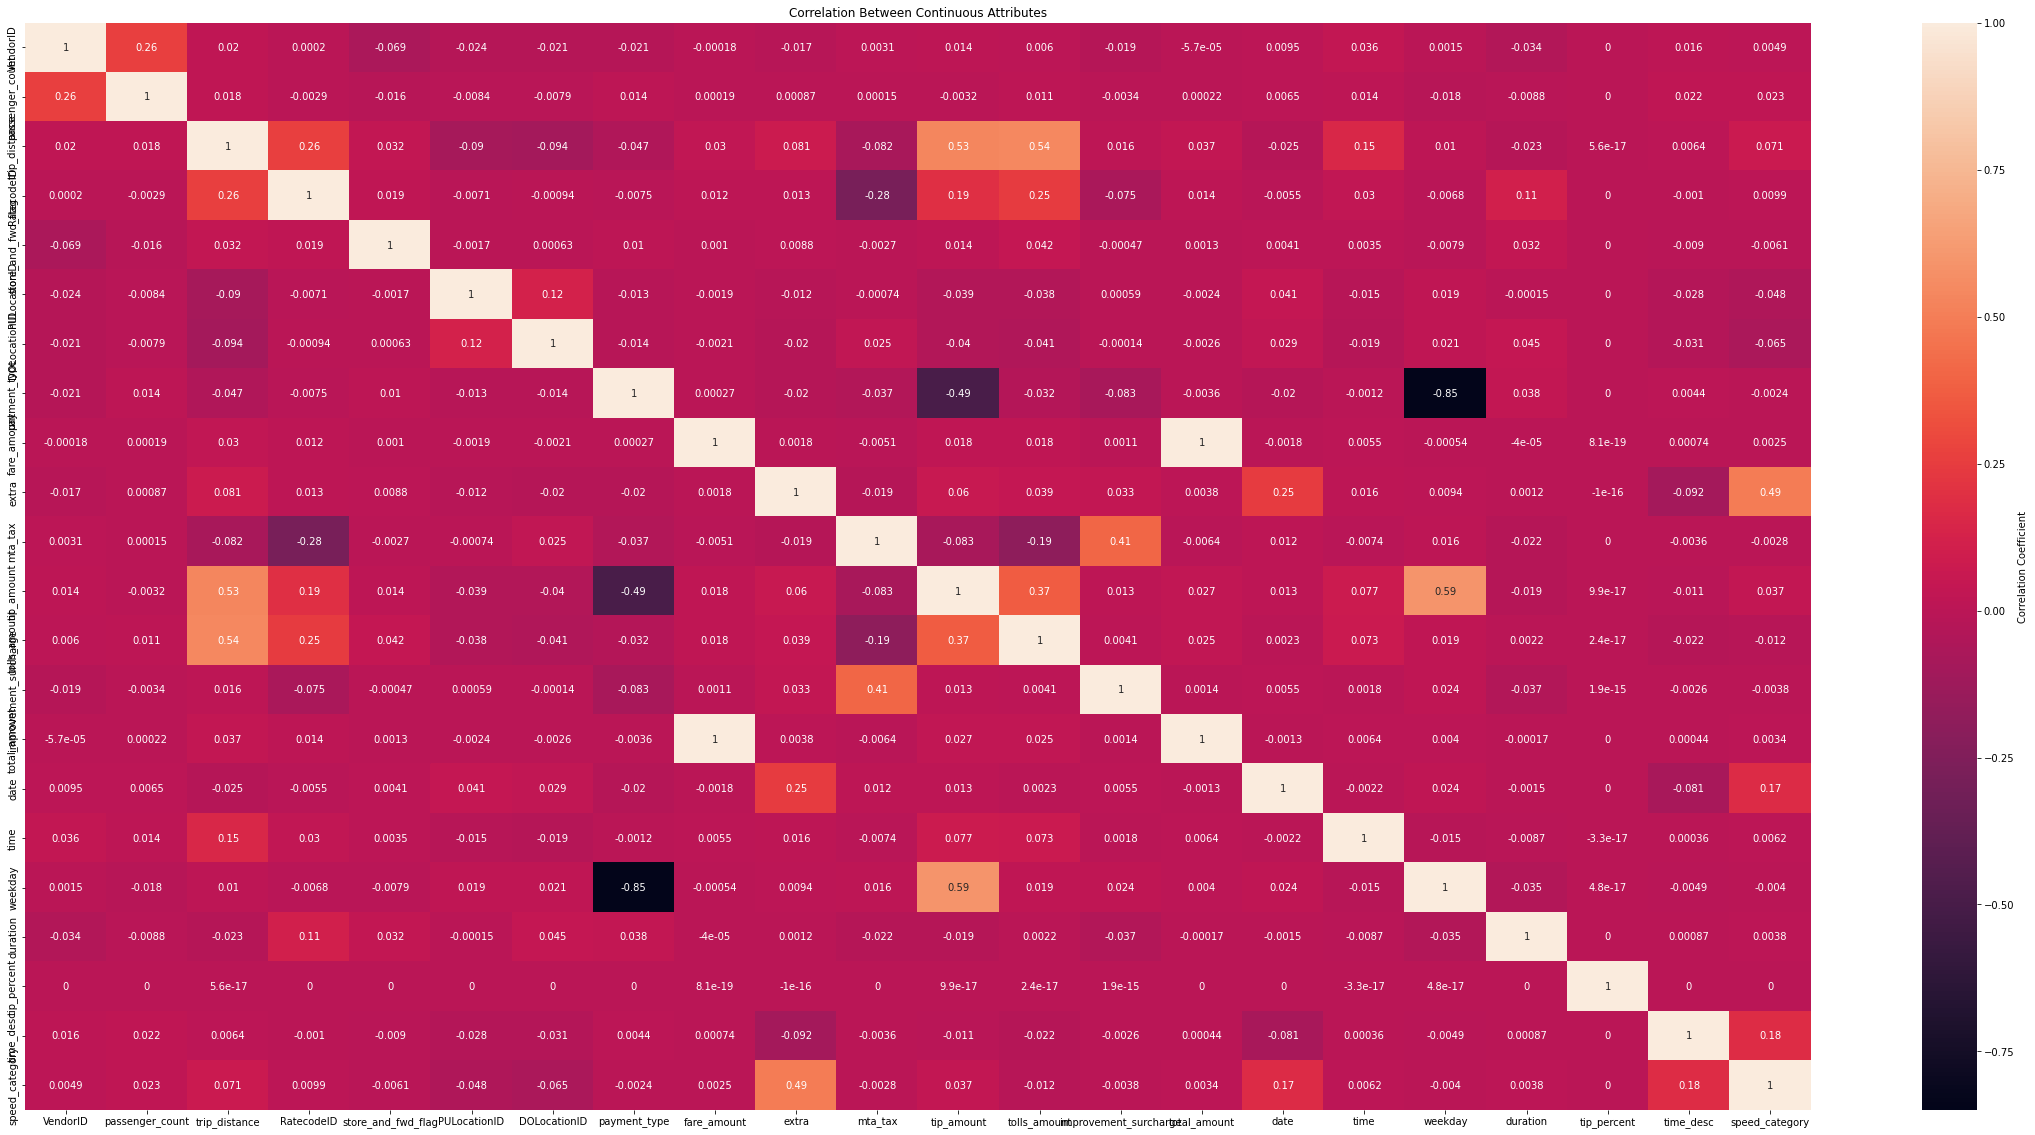

In [ ]:
# 2017
from matplotlib import pyplot as plt
import seaborn as sns

colsNotToInclude = ['airport_fee','tpep_pickup_datetime','tpep_dropoff_datetime','congestion_surcharge','speed']
cols = [col for col in df_2017.columns if col not in colsNotToInclude]

# plot correlation plot
fig, ax = plt.subplots(figsize=(40, 20))
corr_matrix = df_2017[cols].corr()
sns.heatmap(corr_matrix, annot=True, ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
ax.set_xticklabels(cols)
ax.set_yticklabels(cols)
ax.set_title("Correlation Between Continuous Attributes")
plt.show()

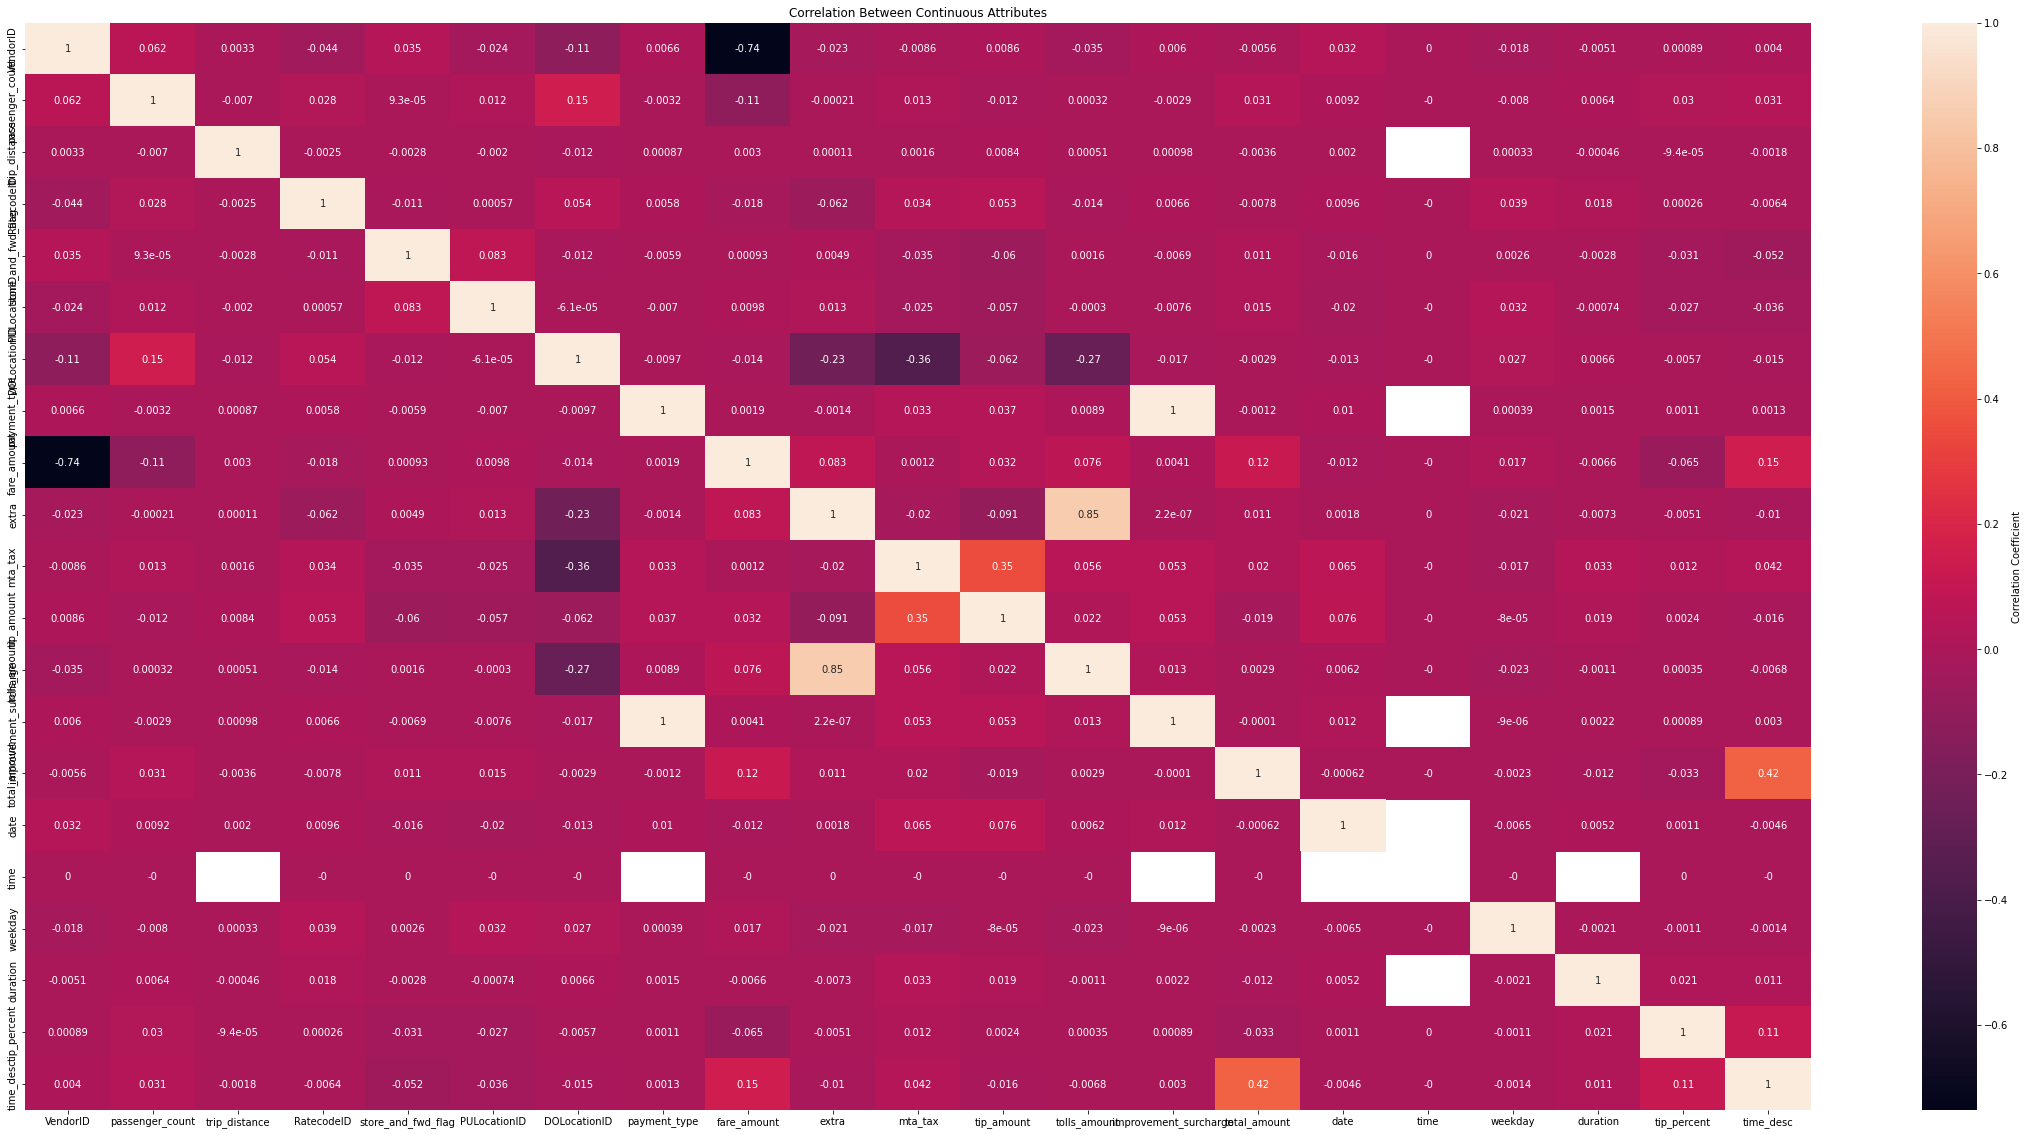

In [23]:
# 2021
from matplotlib import pyplot as plt
import seaborn as sns

colsNotToInclude = ['airport_fee','tpep_pickup_datetime','tpep_dropoff_datetime','congestion_surcharge','speed']
cols = [col for col in df_2021.columns if col not in colsNotToInclude]

# plot correlation plot
fig, ax = plt.subplots(figsize=(40, 20))
corr_matrix = df_2021[cols].corr()
sns.heatmap(corr_matrix, annot=True, ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
ax.set_xticklabels(cols)
ax.set_yticklabels(cols)
ax.set_title("Correlation Between Continuous Attributes")
plt.show()

#Big Data Visualization

#Modelling - feature importances - year 2017

In [ ]:
df_2017_for_modelling = dd.read_parquet("/content/drive/MyDrive/BigData/2017_ALL3_scaled_values.parquet", engine = "pyarrow")
df_2017_target = dd.read_parquet("/content/drive/MyDrive/BigData/2017_TARGET_scaled_values.parquet", engine = "pyarrow")

In [ ]:
features = ['trip_distance','RatecodeID','tolls_amount','time','weekday_num','speed_category']
df_2017_for_modelling = df_2017_for_modelling[features]

In [ ]:
df_2017_for_modelling = df_2017_for_modelling.fillna(0)

In [ ]:
!pip install dask_ml

In [ ]:
# building our model
import dask_ml
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from dask_ml.ensemble import BlockwiseVotingRegressor


linreg = LinearRegression()
knn = KNeighborsRegressor(n_neighbors=5)
forest = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
from dask.distributed import Client
client = Client()

In [ ]:
from joblib import parallel_backend
with parallel_backend('dask'):
  linreg.fit(df_2017_for_modelling, df_2017_target)

In [ ]:
importance = linreg.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 1.12427
Feature: 1, Score: 0.18007
Feature: 2, Score: 0.13403
Feature: 3, Score: 0.01582
Feature: 4, Score: -0.01868
Feature: 5, Score: -0.03049


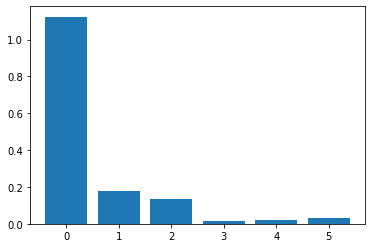

In [ ]:
from matplotlib import pyplot

pyplot.bar([x for x in range(len(importance))], abs(importance))
pyplot.show()

In [ ]:
with parallel_backend('dask'):
  forest.fit(df_2017_for_modelling, df_2017_target)

<ipython-input-12-ddaa0bbfebc4>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(df_2017_for_modelling, df_2017_target)


In [ ]:
with parallel_backend('dask'):
  print(forest.score(df_2017_for_modelling, df_2017_target))

0.6344334545975835


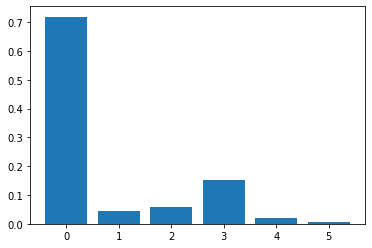

In [ ]:
pyplot.bar([x for x in range(len(forest.feature_importances_))], abs(forest.feature_importances_))
pyplot.show()

In [ ]:
with parallel_backend('dask'):
  knn.fit(df_2017_for_modelling, df_2017_target)

In [ ]:
with parallel_backend('dask'):
  voting = VotingRegressor([('LinReg', linreg), ('KNN', knn), ('RandomForest', forest)])
  voting.fit(df_2017_for_modelling, df_2017_target)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#Modelling - feature importances - year 2021

In [2]:
df_2021_for_modelling = dd.read_parquet("/content/drive/MyDrive/BigData/2017_ALL3_scaled_values.parquet", engine = "pyarrow")
df_2021_target = dd.read_parquet("/content/drive/MyDrive/BigData/2017_TARGET_scaled_values.parquet", engine = "pyarrow")

In [3]:
features = ['passenger_count','RatecodeID','time','mta_tax','improvement_surcharge']
df_2021_for_modelling = df_2021_for_modelling[features]

In [4]:
df_2021_for_modelling = df_2021_for_modelling.fillna(0)

In [ ]:
!pip install dask_ml

In [6]:
# building our model
import dask_ml
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from dask_ml.ensemble import BlockwiseVotingRegressor


linreg = LinearRegression()
knn = KNeighborsRegressor(n_neighbors=5)
forest = RandomForestRegressor(n_estimators=100, random_state=42)

In [7]:
from dask.distributed import Client
client = Client()

In [9]:
from joblib import parallel_backend
with parallel_backend('dask'):
  linreg.fit(df_2021_for_modelling, df_2021_target)

In [13]:
importance = linreg.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.00303
Feature: 1, Score: 0.56603
Feature: 2, Score: 0.01301
Feature: 3, Score: -0.10880
Feature: 4, Score: 0.11370


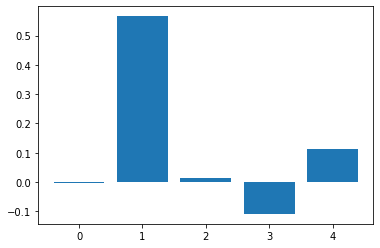

In [14]:
from matplotlib import pyplot

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [10]:
with parallel_backend('dask'):
  forest.fit(df_2021_for_modelling, df_2021_target)

<ipython-input-10-425c19d64493>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(df_2021_for_modelling, df_2021_target)


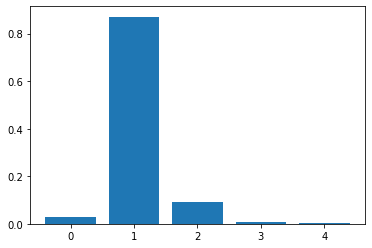

In [15]:
pyplot.bar([x for x in range(len(forest.feature_importances_))], forest.feature_importances_)
pyplot.show()